In [2]:
import keras
keras.__version__

'2.3.1'

In [3]:
import os, shutil

In [19]:
make_dir = lambda x : os.mkdir(x) if not os.path.exists(x) else ''

In [18]:
make_dir(test_pneumoniaBacteria_dir)

''

In [24]:
# The path to the directory where the original
# dataset was uncompressed

# The directory where we will
# store our smaller dataset
base_dir = 'chest_xray'#'/Users/fchollet/Downloads/cats_and_dogs_small'

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
#train_pneumoniaVirus_dir = os.path.join(train_dir, 'pneumoniaVirus')
#train_pneumoniaBacteria_dir = os.path.join(train_dir, 'pneumoniaBacteria')

# Directory with our test cat pictures
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')
#test_pneumoniaVirus_dir = os.path.join(test_dir, 'pneumoniaVirus')
#test_pneumoniaBacteria_dir = os.path.join(test_dir, 'pneumoniaBacteria')
                                        
# Directory with our validation 
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')
#validation_pneumoniaVirus_dir = os.path.join(validation_dir, 'pneumoniaVirus')
#validation_pneumoniaBacteria_dir = os.path.join(validation_dir, 'pneumoniaBacteria')


In [25]:
dirContentV = []
dirContentB = []

In [22]:
def move(src, dest):
    if ('pneumoniaVirus' not in dest):
        shutil.copy(src,dest)
    elif ('pneumoniaBacteria' not in dest):
        shutil.copy(src, dest)
        

In [23]:
# split pneumonia i virus and bacteria
# train
dirContentV = os.listdir(train_pneumoniaVirus_dir)
dirContentB = os.listdir(train_pneumoniaBacteria_dir)
for f in os.listdir(train_pneumonia_dir):
    if('virus' in f):
        move(os.path.join(train_pneumonia_dir,f),train_pneumoniaVirus_dir)
    elif('bacteria' in f):
        move(os.path.join(train_pneumonia_dir,f),train_pneumoniaBacteria_dir)

#test
dirContentV = os.listdir(test_pneumoniaVirus_dir)
dirContentB = os.listdir(test_pneumoniaBacteria_dir)
for f in os.listdir(test_pneumonia_dir):
    if('virus' in f):
        move(os.path.join(test_pneumonia_dir,f),test_pneumoniaVirus_dir)
    elif('bacteria' in f):
        move(os.path.join(test_pneumonia_dir,f),test_pneumoniaBacteria_dir)

#val
dirContentV = os.listdir(validation_pneumoniaVirus_dir)
dirContentB = os.listdir(validation_pneumoniaBacteria_dir)
for f in os.listdir(validation_pneumonia_dir):
    if('virus' in f):
        move(os.path.join(validation_pneumonia_dir,f),validation_pneumoniaVirus_dir)
    elif('bacteria' in f):
        move(os.path.join(validation_pneumonia_dir,f),validation_pneumoniaBacteria_dir)


FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'chest_xray\\train\\pneumoniaVirus'

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [26]:
print('total training normal images:', len(os.listdir(train_normal_dir)))

total training normal images: 1342


In [27]:
print('total training pneumonia images:', len(os.listdir(train_pneumonia_dir)))

total training pneumonia images: 3876


In [28]:
print('total validation normal images:', len(os.listdir(validation_normal_dir)))

total validation normal images: 9


In [29]:
print('total validation pneumonia images:', len(os.listdir(validation_pneumonia_dir)))

total validation pneumonia images: 9


In [30]:
print('total test normal images:', len(os.listdir(test_normal_dir)))

total test normal images: 234


In [31]:
print('total test pneumonia images:', len(os.listdir(test_pneumonia_dir)))

total test pneumonia images: 390



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

In [38]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               160580096 
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 160,581,505
Trainable params: 160,581,505
Non-trainable params: 0
_________________________________________________________________


For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to 
use in various situations).

In [40]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [41]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(200, 200),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(200, 200),
        batch_size=20,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [42]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [43]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/20
100/100 [==============================] - 246s 2s/step - loss: 0.7028 - acc: 0.7645 - val_loss: 0.5027 - val_acc: 0.6875
Epoch 2/20
100/100 [==============================] - 220s 2s/step - loss: 0.3095 - acc: 0.8625 - val_loss: 0.3363 - val_acc: 0.8750
Epoch 3/20
100/100 [==============================] - 218s 2s/step - loss: 0.2268 - acc: 0.9018 - val_loss: 0.5312 - val_acc: 0.6875
Epoch 4/20
100/100 [==============================] - 215s 2s/step - loss: 0.1656 - acc: 0.9395 - val_loss: 1.2949 - val_acc: 0.6250
Epoch 5/20
100/100 [==============================] - 218s 2s/step - loss: 0.1437 - acc: 0.9450 - val_loss: 0.6421 - val_acc: 0.6250
Epoch 6/20
100/100 [==============================] - 220s 2s/step - loss: 0.1207 - acc: 0.9545 - val_loss: 0.7861 - val_acc: 0.6250
Epoch 7/20
100/100 [==============================] - 218s 2s/step - loss: 0.1039 - acc: 0.9564 - val_loss: 0.3640 - val_acc: 0.7500
Epoch 8/20
100/100 [==============================] - 221s 2s/step - 

It is good practice to always save your models after training:

In [44]:
model.save('pneumonia-2.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

Tras entrenar con una red muy compleja se obtienen estos resultdos en los que observamos un sobre entrenamiento y una precisión bastante mala

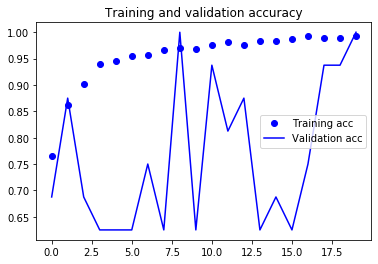

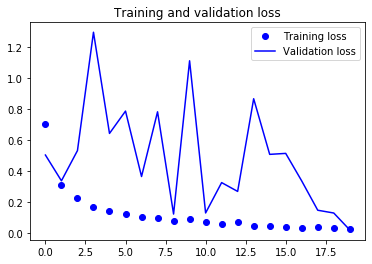

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()